### 캘리포니아 주택 가격 예측
인구, 중간소득 등의 특성을 활용하여 중간 주택가격예측     

레이블된 훈련 샘플이 있고 값을 예측해야하는 문제이기 때문에 지도학습의 회귀 문제이다. 사용할 특성이 여러개기 때문에 단변량회귀, 구역마다 여러 값을 예측한다면 다변량 회귀문제 입니다. 시스템으로 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고 , 데이터가 메모리에 들어갈 만큼 충분히 작으므로 일반적인 배치 학습이 적절합니다.

#### 성능 지표 선택
회귀문제의 전형적인 성능 지표는 평균제곱오차(RMSE) 오차가 커질 수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠하게 해준다.  
평균절대오차(MAE) 이상치로 보이는 구역이 많을 시 유용

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:>

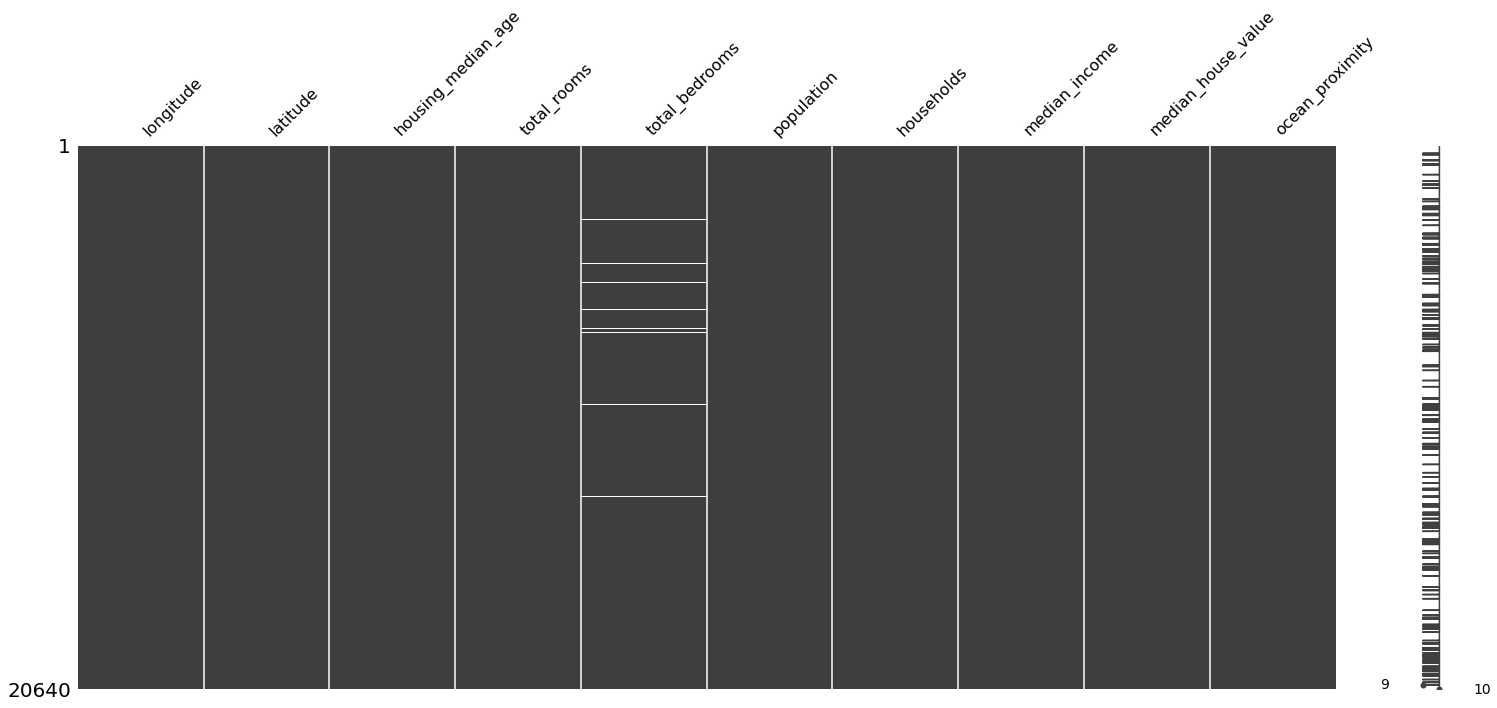

In [5]:
# null 값 시각화
import missingno as msno

msno.matrix(df)

In [6]:
# null 값 보기 
tot = df.isnull().sum().sort_values(ascending=False)
pct = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([tot, pct], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
total_bedrooms,207,0.010029
longitude,0,0.000000
latitude,0,0.000000
housing_median_age,0,0.000000
total_rooms,0,0.000000
population,0,0.000000
households,0,0.000000
median_income,0,0.000000
median_house_value,0,0.000000
ocean_proximity,0,0.000000


In [7]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


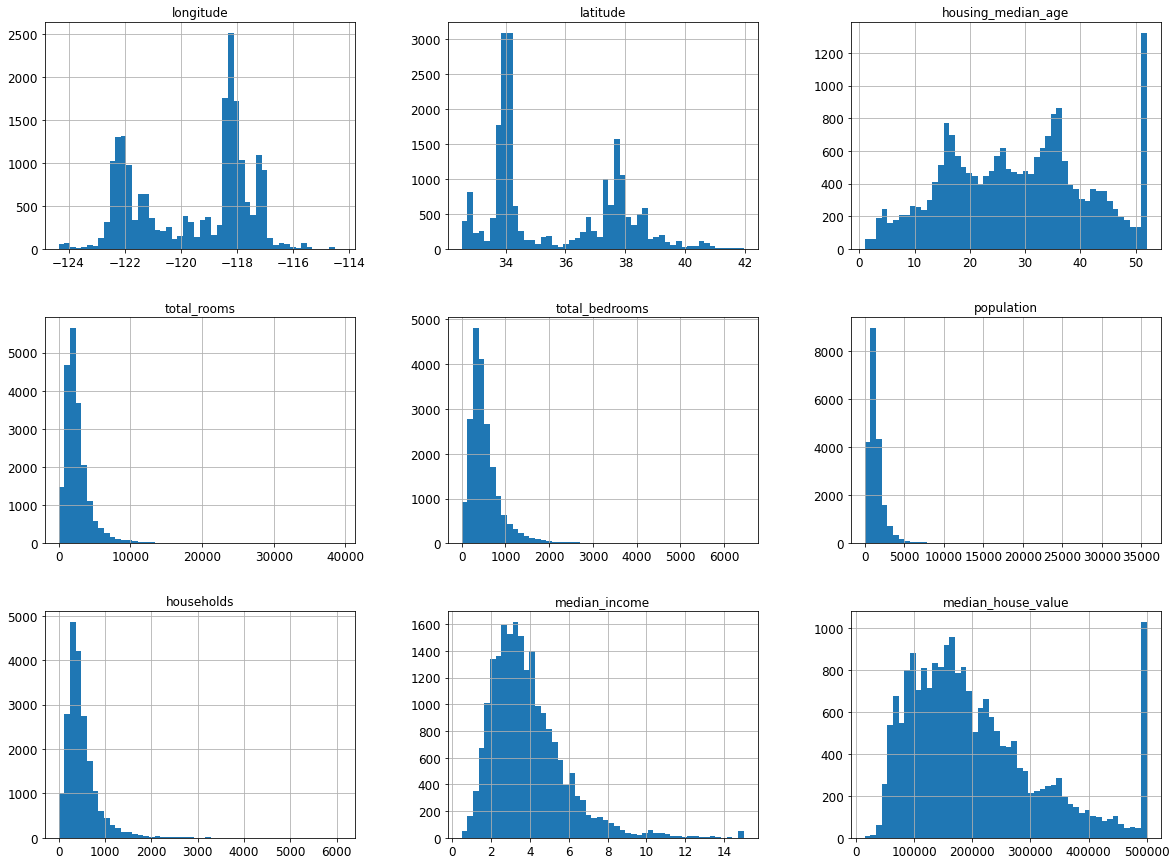

In [9]:
# 수치형 데이터 히스토그램
# housing_median_age , median_house_value 최소값과 최댓값이 한정되 있다.
# 컬럼값들의 단위가 다름으로 스케일링 필요 
# 정상적인 가우시안분포를 갖고 있지 않고 왼쪽으로 치우침이 있기 때문에 조정 필요 이런 형태는 일부 머신러닝 알고리즘에서 
# 패턴을 찾기 어렵게 만들기 때문에 특성들을 좀 더 종 모양의 분포가 되도록 변형 요망  

df.hist(bins=50, figsize=(20,15))
plt.show()

### Testset 

In [10]:
# train_test_split 함수 

def split_train_test(data, test_ratio):
    # permutation (순열) 정수배열을 랜덤하게 섞는다.
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(df, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [15]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [16]:
housing_with_id = df.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [17]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [18]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

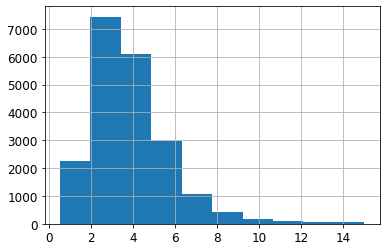

In [20]:
df["median_income"].hist()
plt.show()

In [21]:
# 중요도가 높은 컬럼인 median_income을 수치형에서 카테고리로 변경 ,여러 소득 카테고리를 대표하기 위해서
df['income_cat'] = pd.cut(df['median_income'] , bins = [0.,1.5,3.0,4.5,6, np.inf], labels =[1,2,3,4,5,])

In [22]:
df['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

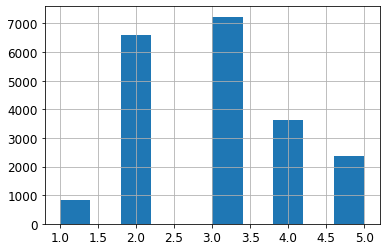

In [23]:
df['income_cat'].hist()
plt.show()

In [24]:
# 새로 생성한 imcome_cat 컬럼을 test, train에 균등하게 나누는 계층적 샘플링

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [26]:
df["income_cat"].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [27]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### EDA 탐색적 분석

In [29]:
# 원본 데이터 손상을 막기 위해 copy 

h = strat_train_set.copy()
h.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


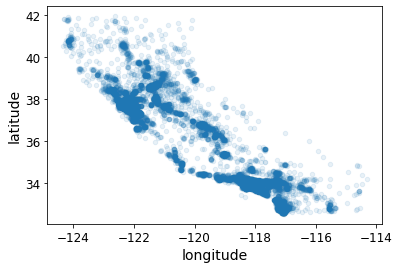

In [30]:
h.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)
plt.show()

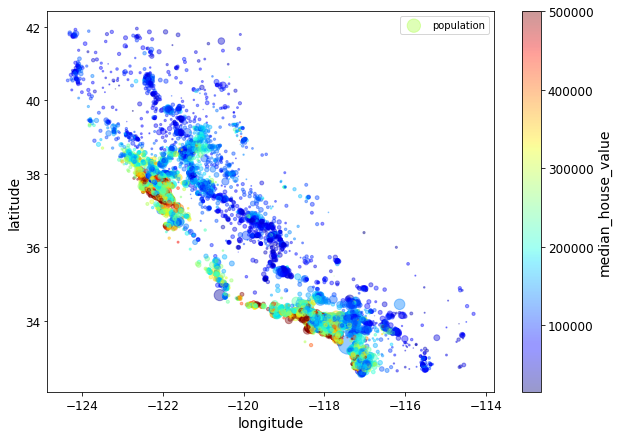

In [31]:
# 주택가격 파악 
h.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=h["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show()


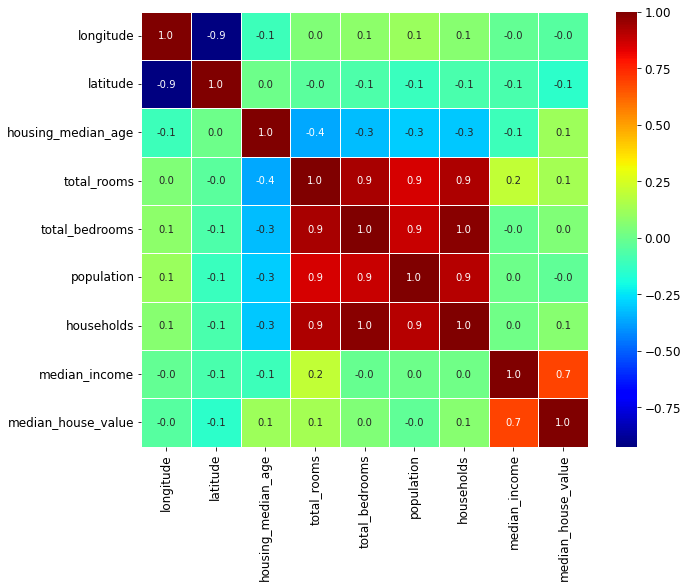

In [32]:
# 변수간 상관관계 파악 

fig ,ax  = plt.subplots(figsize = (10,8))
c = h.corr()
sns.heatmap(c , annot = True , fmt ='.1f' , linewidths  = .5 , cmap = 'jet')
plt.show()

In [33]:
# median_house_value 상관관계 파악 

corr_matrix = h.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

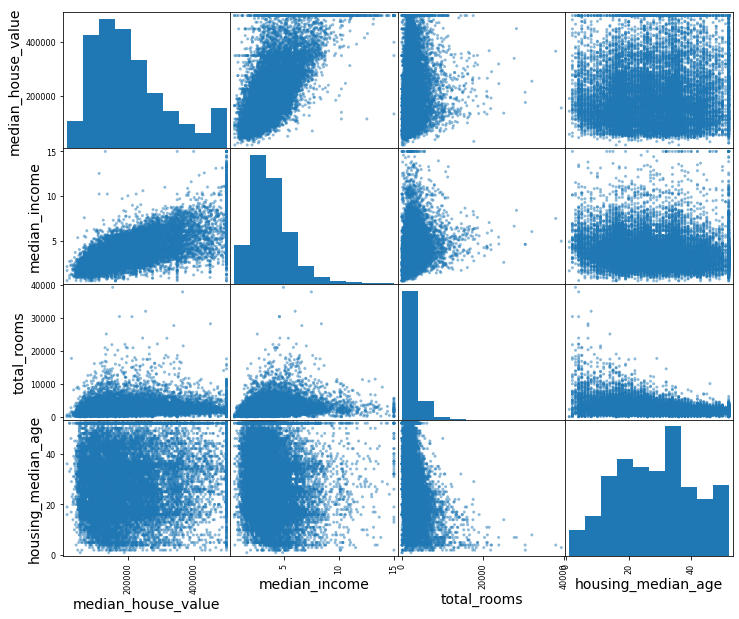

In [34]:
# 목표변수와 상관관계가 있는 수치형 변수 산점도 

from pandas.plotting import scatter_matrix

a = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(h[a] , figsize = (12, 10))
plt.show()

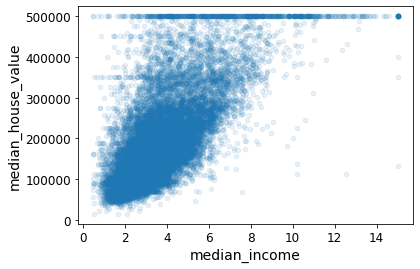

In [35]:
h.plot(kind = 'scatter',x = 'median_income' ,y = 'median_house_value' ,alpha = 0.1)
plt.show()

### 특성조합 

In [36]:
h.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [37]:
# 특정 구역의 방 개수는 얼마나 많은 가구 수가 있는 지 모른다면 유용하지 않는다. 필요한 것은 가구당 방 개수 
# 전체 침실 갯수 보다 방개수와 비교 필요
# 가구당 인원 

h["rooms_per_household"] = h["total_rooms"]/h["households"]
h["bedrooms_per_room"] = h["total_bedrooms"]/h["total_rooms"]
h["population_per_household"]=h["population"]/h["households"]

In [38]:
corr_matrix = h.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

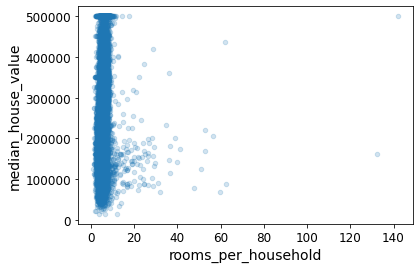

In [39]:
h.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

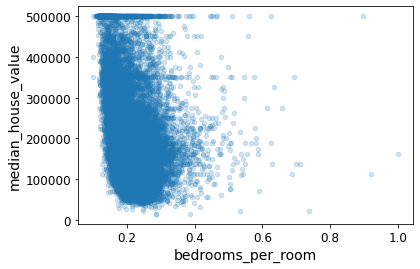

In [40]:
h.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.show()

In [41]:
h.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


### 머신러닝 알고리즘을 위한 데이터 준비 
작업을 수동으로 하는 대신 함수를 만들어 자동화 해야하는 이유
* 어떤 데이터셋에 대해서도 데이터 변환을 손쉽게 반복할 수 있다.(다음번에 새로운 데이터셋을 사용할때)
* 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
* 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는데 이 함수를 사용할 수 있다.
* 여러가지 데이터변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는데 편리하다.

In [42]:
h = strat_train_set.drop('median_house_value' ,axis = 1)
h_label = strat_train_set.median_house_value

### 데이터 정제(preprocessing)
대부분의 머신러닝 알고리즘은 누락된 특성을 다루지 못한기 때문에 처리필요
* 해당 구역을 제거 
* 전체 특성을 제거
* 어떤 값으로 채운다.(0 , 평균, 중간값등)




In [43]:
sample_incomplete_rows = h[h.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [44]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [45]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [46]:
median = h["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

In [47]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [48]:
# simpleimputer 

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'median')

In [49]:
# 수치형 특성에만 적용되기 때문에 범주형 제거

housing_num = h.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [50]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [52]:
# 값 비교
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [53]:
X = imputer.transform(housing_num)

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [55]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [56]:
imputer.strategy

'median'

In [57]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### 텍스트와 범주형 특성 다루기

In [58]:
housing_cat = h[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


특성은 범주형 특성으로 5개의 범주를 가진 텍스트 특성입니다. 대부분의 머신러닝 알고리즘은 수치형 데이터를 다루므로 이 범주형 특성을 텍스트에서 숫자형 데이터로 변환시키는 작업이 필요  

작업을 위해 sklearn의 OrdinalEnoder를 사용하겠습니다. 이는 문자열 데이터를 정수형 데이터로 순서대로 변환하는 기능을 지원  


In [59]:
# 범주형을 수치형으로 변환 
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_endcoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_endcoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

범주형 특성들이 수치형 특성으로 변환된 결과  

이 표현 방식에는 문제점이 존재합니다.  

대부분의 머신러닝 알고리즘은 가까이 있는 두 값이 떨어져 있는 거리를 기준으로 삼아 학습을 진행하기 때문에 거리적으로 가까운 특성이 아닌 수치형으로 변환된 특성으로 특성간의 거리를 측정한다는 것입니다.   

예를 들어 Bad, Average, Good, Excellent와 같은 순서가 있는 카테고리의 경우는 괜찮지만 ocean_proximity 특성의 경우 <1H OCEAN, INLAND 의 비슷함보다 <1H OCEAN 와 NEAR OCEAN 이 훨씬 의미적으로 비슷하기 때문입니다.  
  
문제의 해결책은 카테고리별 이진 특성을 만들어 해결하는 것입니다.  
  
 방법을 원-핫 인코딩(one-hot encoding)이라고 부릅니다. 이따금 새로운 특성을 더미 특성이라고도 부릅니다.  
  
 sklearn에서는 이러한 범주의 값을 원 핫 벡터로 변환하기 위한 OnOneHotEncoder 클래스를 제공  

In [60]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

OneHotEncoder의 결과물은 사이파이 희소 행령입니다. 이는 수천개의 카테고리가 있는 경우에는 매우 효율적으로 작동할 수 있습니다. 이런 특성을 원-핫 인코딩하면 열이 수천개인 행렬로 변하고 각 행은 1이 하나뿐인 행렬로 나타나게 됩니다. 따라서 0을 모두 메모리에 저장하는 것은 낭비이므로 0이 아닌 원소의 위치만 저장하는 희소행렬로 출력됩니다. 하지만 필요에 따라서 toarary()메소드 혹은 sparse=False 파라미터를 사용해 밀집 배열로 변환할 수 있습니다 .



In [61]:
housing_cat_1hot.toarray() # toarray() 메서드를 사용해 밀집 배열로 변환

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
# 변환기 생성 
# sklearn.base의 TransformerMixin을 상속하면 fit, transform메서드만 만들어도 자동으로 fit_transform()메서드를 자동으로 생성해준다.
#sklearn.base의 BaseEstimator를 상속하면 하이퍼파라미터 튜닝에 필요한 두 메서드 get_params()와 set_params()를 추가로 얻게 된다. 
# (생성자에 *args나 **kargs 사용하면 안됨)


 
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(h.to_numpy())

간단하게 인덱스 (3, 4, 5, 6)을 하드코딩했지만 다음처럼 동적으로 처리하는 것이 더 좋다

In [64]:
# get_loc 위치와 값을 혼용해서 사용 가능 

col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    h.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

In [65]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(h.columns)+["rooms_per_household", "population_per_household"],
    index=h.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


### 특성 스케일링 
머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 못함, **타깃값에 대한 스케일링은 일반적으로 불필요**

MinMaxScaling(정규화라고도 부른다) 0~1 범위에 들도록 값을 이동하고 스케일을 조정 , 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나누면 된다.  

표준화는 정규화와 다르다. 먼저 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다. 표준화는 범위의 상한과 하한이 없어 어떤 알고리즘에서는 문제가 될 수 있다. 그러나 표준화는 이상치에 영향을 덜 받는다.

**모든 변환기에서 스케일링은 전체 데이터가 아니고 훈련데이터에 대해서만 fit()메서드를 적용하여야 한다.** 훈련세트와 테스트세트(또한 새로운 데이터)에 대해 transform()메서드를 사용한다.

### 변환 파이프라인 
변환 단계가 많으면 정확한 순서대로 실행되어야 하는데 연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline 클래스가 있다.

In [68]:
### 숫자 특성 처리 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

imp = SimpleImputer(strategy='median')

step = [('imputer',imp),
         ('attr_adder' , CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())]



num_pipeline = Pipeline(step)

housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipeline은 연속된 단계를 나타내는 이름/추정기 쌍의 목록을 입력으로 받는다. 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있고 그 외에는 모두 변환기여야 한다.(즉 fit_trasform 메서드를 가지고 있어야 한다)

In [69]:
# 하나의 변환기로 각 열마다 변환적용 (수치형, 범주형 범용)
# ColumnTransfomer 사용
#추정기를 사용하면 입력의 다른 열 또는 열 하위 집합을 개별적으로 변환 할 수 있으며 각 변환기에서 생성 된 특성이 연결되어 단일 특성 공간을 형성합니다. 
#이기종 또는 열 형식의 데이터에서 여러 기능 추출 메커니즘 또는 변환을 단일 변환기로 결합하는 데 유용

from sklearn.compose import ColumnTransformer

num_attribute = list(housing_num)
cat_attribute = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num',num_pipeline, num_attribute),
                                   ('cat',OneHotEncoder() , cat_attribute)])

housing_prepared = full_pipeline.fit_transform(h)

수치형 열 이름의 리스트와 범주형 열 이름의 리스트를 만든다. ColumnsTransformer  클래스 객체 생성, 생성자는 튜플의 리스트를 받는다. 각 튜플은 이름, 변환기, 변환기가 적용될 열 이름의 리스트로 이루어 진다.

OnehotEncoder는 희소행렬을 반환하지만 num_pipeline은 밀집행렬을 반환 ,회소행렬과 밀집행렬이 섞여 있을때 ColumnsTransformer는 최종 행렬의 밀집정도를 추정한다.(즉 0인 아닌 원소의 비율). 밀집도가 임곗값(기본적으로 sparse_threshold = 0.3) 보다 낮으면 희소행렬을 반환 